In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

tract_info = pd.read_csv('data/tract_info.csv')
cortices = list(set(tract_info.cortex))

df_subject = pd.read_csv('data/subject_info.csv')
df_areas = pd.read_csv('data/tract_cross-sectional-areas.csv')
df = pd.merge(df_subject, df_areas, on='id')

display(df)

,id,age,sex,site,AF-L__Hipp-L_0,AF-L__Hipp-L_1,CG-L__CC__Hipp-L,CG-L__CC-isthmus__POS1-L_0,AF-L__Hipp-L_2,CC__Hipp-R,...,AF-L__Hipp-R_3,CG-L__CC__V2-L,AF-L__Hipp-L_5,IFO-R__PHA2-R_1,CC__V2-R,CC__CC-isthmus__CG-R__Hipp-R,AF-L__Hipp-R_4,IFO-R__ST-OCC-R__AF-L__Hipp-R,AF-L__FX-L__Hipp-L_1,CC__ILF-L__PHA3-L
0,HCD0001305,11.916667,M,WashU,12.492314,45.948628,30.660106,0.637349,19.315874,4.014349,...,0.126090,0.596419,75.636652,7.823236,1.347300,0.315052,41.666059,6.953296,13.126395,1.840375
1,HCD0008117,16.000000,F,Harvard,8.569758,16.414851,20.465766,1.045508,25.984212,3.048386,...,0.328334,0.745486,39.566787,5.701181,0.613398,1.199195,49.064373,2.756810,1.465629,2.315826
2,HCD0021614,9.166667,F,Harvard,13.664400,20.100192,21.881002,0.914247,24.288038,2.593510,...,0.377367,0.936888,39.828287,8.416934,1.244614,1.100831,62.448173,4.250448,0.764498,17.686912
3,HCD0022919,9.750000,F,UCLA,8.145933,38.417246,49.448629,0.972176,29.207022,3.494819,...,0.832285,0.893005,25.736385,16.929673,0.988442,0.322050,42.797630,10.479829,2.328043,1.489937
4,HCD0026119,15.166667,F,Harvard,47.245156,49.228183,31.566864,0.984765,13.406142,2.268093,...,0.902526,0.817198,62.440291,7.925952,1.088180,0.000000,63.691935,9.128708,14.516532,0.143935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,HCD2978386,9.166667,M,UMinn,5.760724,12.941554,17.122665,0.944236,12.814879,3.854952,...,0.075095,1.072270,40.501157,7.399635,0.992633,0.942437,22.557615,0.272407,0.388397,1.709457
535,HCD2982579,18.750000,F,Harvard,19.673321,23.038178,28.887326,1.138459,20.916148,1.796392,...,0.291191,0.667545,43.755998,10.887571,0.642886,0.049749,51.279669,11.141329,8.097025,0.466146
536,HCD2987185,14.583333,M,UMinn,7.963692,28.980848,38.550812,1.627673,18.021602,3.807203,...,0.489630,1.139409,51.958825,14.275613,1.624296,0.647867,39.495069,5.517050,2.153107,3.150470
537,HCD2990073,13.583333,F,Harvard,20.310970,36.525024,26.188280,1.494767,18.840424,5.715446,...,0.695240,0.868245,62.043465,8.720110,2.129984,1.202670,30.424541,8.439853,2.999365,1.450308


In [19]:
from pygam import GAM, s


def fit_gam(x: np.array, y: np.array, lam=1e3, n_values=500):

    g = GAM(s(0), lam=lam).fit(x, y)

    x_grid = np.linspace(x.min(), x.max(), n_values)
    y_grid = g.predict(x_grid)

    ci = g.confidence_intervals(x_grid, width=0.95)

    return x_grid, y_grid, ci


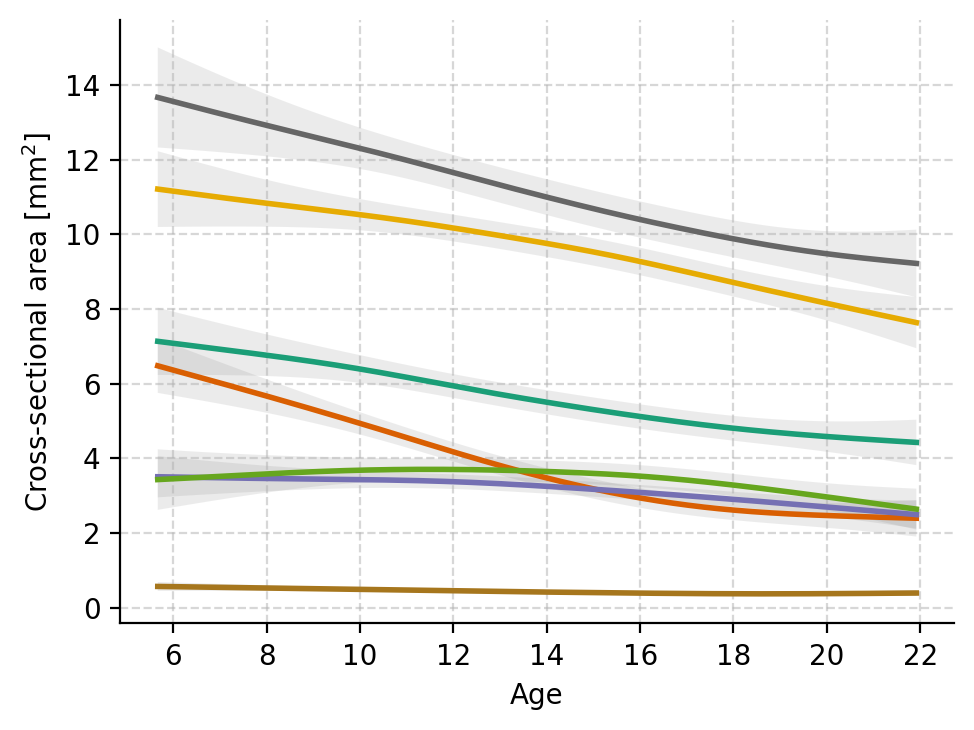

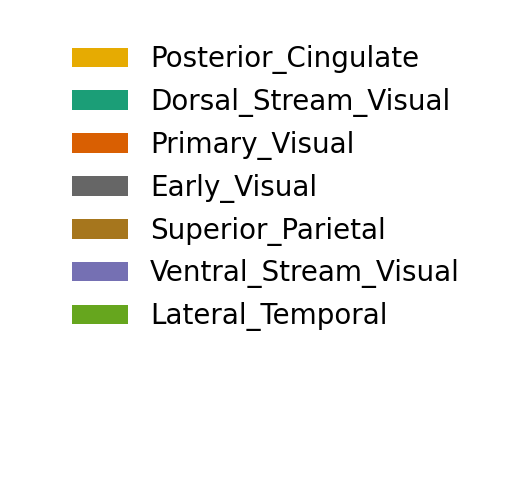

In [20]:


tract_colors = dict(zip(cortices, plt.get_cmap('Dark2').colors))

cortices = tract_info[~np.isin(tract_info.cortex, ['Medial_Temporal'])].cortex.unique()


fig, ax = plt.subplots(figsize=(5, 3.75))


for idx, cortex in enumerate(cortices):

    tracts = tract_info[tract_info.cortex == cortex]['label']
    tract_area = df[tracts].sum(axis=1)

    x_grid, y_grid, ci = fit_gam(df['age'].values, tract_area)

    ax.plot(
        x_grid, y_grid,
        lw=2,label=cortex, color=tract_colors[cortex]
    )
    ax.fill_between(
        x_grid, ci[:,0], ci[:,1],
        facecolor='tab:gray', alpha=0.15
    )


ax.set_xlabel('Age')
ax.set_ylabel('Cross-sectional area [mm$^2$]')
ax.grid(linestyle='--', alpha=.5)
sns.despine()
plt.tight_layout()
plt.savefig(f'plots/tract_area_development.svg')

fig, ax = plt.subplots(figsize=(3,3))

for cortex in cortices:
    ax.bar(0,0, color=tract_colors[cortex], label=cortex)

ax.legend(frameon=False)
ax.axis('off')
plt.savefig(f'plots/tract_area_development_legend.svg')
plt.show()

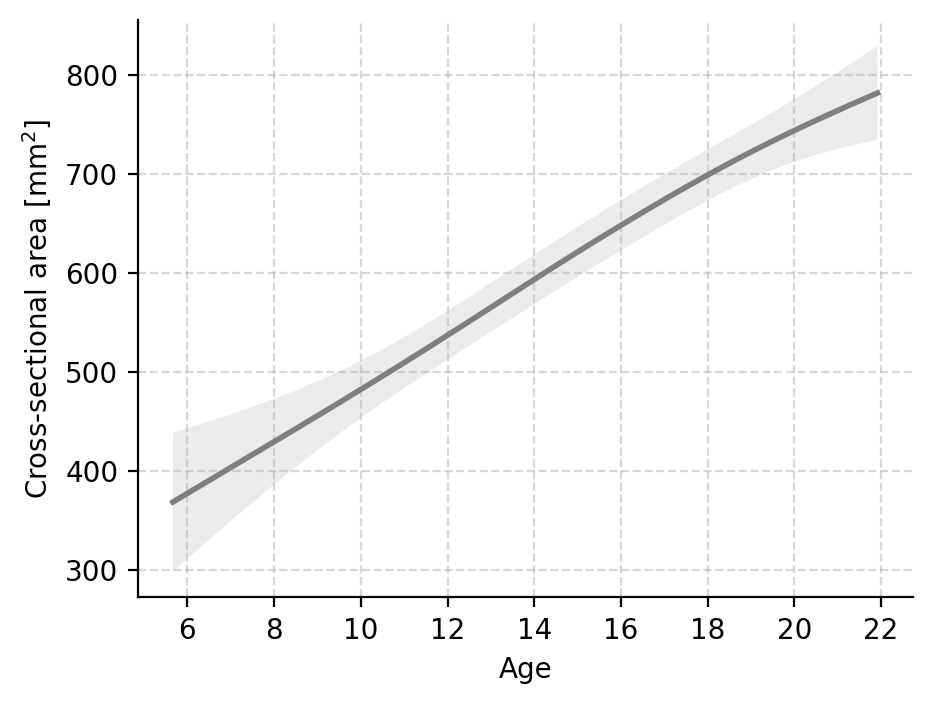

In [21]:
fig, ax = plt.subplots(figsize=(5, 3.75))

tracts = tract_info[tract_info.cortex == 'Medial_Temporal']['label']
tract_area = df[tracts].sum(axis=1)

x_grid, y_grid, ci = fit_gam(df['age'].values, tract_area)

ax.plot(x_grid, y_grid, lw=2,label=cortex, color='tab:gray')
ax.fill_between(x_grid, ci[:,0], ci[:,1], facecolor='tab:gray', alpha=0.15)


ax.set_xlabel('Age')
ax.set_ylabel('Cross-sectional area [mm$^2$]')
ax.grid(linestyle='--', alpha=.5)
plt.savefig(f'plots/tract_area_development_medial_temporal.svg')
sns.despine()

In [22]:
for cortex in cortices:
    tracts = tract_info[tract_info.cortex == cortex]['label']
    print(f'{cortex}:')
    display(pg.linear_regression(X=df['age'], y=df[tracts].sum(axis=1)))


Posterior_Cingulate:


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,12.889534,0.497627,25.902006,1.365297e-96,0.086505,0.084803,11.912000,13.867067
1,age,-0.232751,0.032639,-7.131047,3.234247e-12,0.086505,0.084803,-0.296867,-0.168635


Dorsal_Stream_Visual:


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,8.086894,0.441777,18.305362,1.588733e-58,0.065552,0.063812,7.219070,8.954717
1,age,-0.177844,0.028976,-6.137640,1.628324e-09,0.065552,0.063812,-0.234764,-0.120924


Primary_Visual:


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,7.259425,0.359755,20.178792,8.198945e-68,0.171827,0.170285,6.552725,7.966125
1,age,-0.249066,0.023596,-10.555338,8.529554e-24,0.171827,0.170285,-0.295418,-0.202714


Early_Visual:


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,15.021164,0.656886,22.867244,2.527128e-81,0.072759,0.071033,13.730784,16.311545
1,age,-0.279679,0.043085,-6.491361,1.937490e-10,0.072759,0.071033,-0.364315,-0.195044


Superior_Parietal:


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.590611,0.058111,10.163570,2.589785e-22,0.016003,0.014171,0.476459,0.704762
1,age,-0.011264,0.003811,-2.955237,3.261446e-03,0.016003,0.014171,-0.018751,-0.003777


Ventral_Stream_Visual:


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,4.162976,0.270963,15.363607,2.033998e-44,0.028813,0.027005,3.630697,4.695254
1,age,-0.070938,0.017772,-3.991458,7.479917e-05,0.028813,0.027005,-0.105850,-0.036026


Lateral_Temporal:


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,4.397565,0.398330,11.040004,1.116869e-25,0.011691,0.009851,3.615089,5.180041
1,age,-0.065849,0.026126,-2.520394,1.201107e-02,0.011691,0.009851,-0.117171,-0.014526


In [23]:
cortices = list(set(tract_info.cortex))

df_subject = pd.read_csv('data/subject_info.csv')
df_myelin = pd.read_csv('data/tract_myelin.csv')
df = pd.merge(df_myelin, df_subject, on='id')

display(df)

,id,AF-L__Hipp-L_0,AF-L__Hipp-L_1,CG-L__CC__Hipp-L,CG-L__CC-isthmus__POS1-L_0,AF-L__Hipp-L_2,CC__Hipp-R,CG-L__CC__POS2-L,CC__CC-splenium__ProS-R,CG-L__CC__V3A-L,...,IFO-R__PHA2-R_1,CC__V2-R,CC__CC-isthmus__CG-R__Hipp-R,AF-L__Hipp-R_4,IFO-R__ST-OCC-R__AF-L__Hipp-R,AF-L__FX-L__Hipp-L_1,CC__ILF-L__PHA3-L,age,sex,site
0,HCD0001305,2.569012,1.988319,2.134632,3.350018,2.071011,3.652546,3.418096,3.611914,3.446657,...,1.870674,3.680132,3.307465,1.565999,1.425106,1.835203,3.604128,11.916667,M,WashU
1,HCD0008117,2.495664,2.299665,2.611950,3.784277,2.163350,4.502670,3.708516,4.490670,3.634855,...,2.205093,4.285308,4.037622,1.932826,1.891955,2.103837,3.622794,16.000000,F,Harvard
2,HCD0021614,2.442599,2.077043,2.447455,3.735597,2.050329,4.399982,3.736149,4.352942,3.670106,...,2.163555,4.398211,3.894909,1.802345,1.578739,1.769459,2.364199,9.166667,F,Harvard
3,HCD0022919,2.770714,2.163989,2.006122,3.787136,2.133248,4.227040,3.794777,4.225202,3.760604,...,2.058220,4.268271,3.985097,2.095391,1.837646,1.904557,3.528608,9.750000,F,UCLA
4,HCD0026119,1.865522,1.959974,2.223699,3.916404,2.221135,4.662705,3.690060,4.621059,3.739739,...,2.521787,4.509507,NaN,1.856848,1.987382,1.829066,3.736888,15.166667,F,Harvard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,HCD2978386,2.324980,2.023812,2.163753,3.125044,2.089318,3.667870,3.361763,3.718082,3.437786,...,1.981665,3.700012,3.381752,1.875858,1.595335,1.805524,3.030677,9.166667,M,UMinn
535,HCD2982579,2.684971,2.728230,2.677400,3.969661,2.287055,4.527654,3.989334,4.515096,3.812704,...,2.443831,4.511630,4.472784,2.136140,1.974416,1.970593,3.986428,18.750000,F,Harvard
536,HCD2987185,2.781591,2.226159,1.985347,3.794325,2.327406,4.386891,3.739977,4.376356,3.691775,...,2.050001,4.146615,4.034883,1.874605,1.685675,2.116147,3.634319,14.583333,M,UMinn
537,HCD2990073,1.844699,1.733447,2.075545,3.393474,1.967687,3.950091,3.389927,4.020093,3.366845,...,2.081800,3.850075,3.683315,1.864199,1.665186,1.597908,3.099190,13.583333,F,Harvard


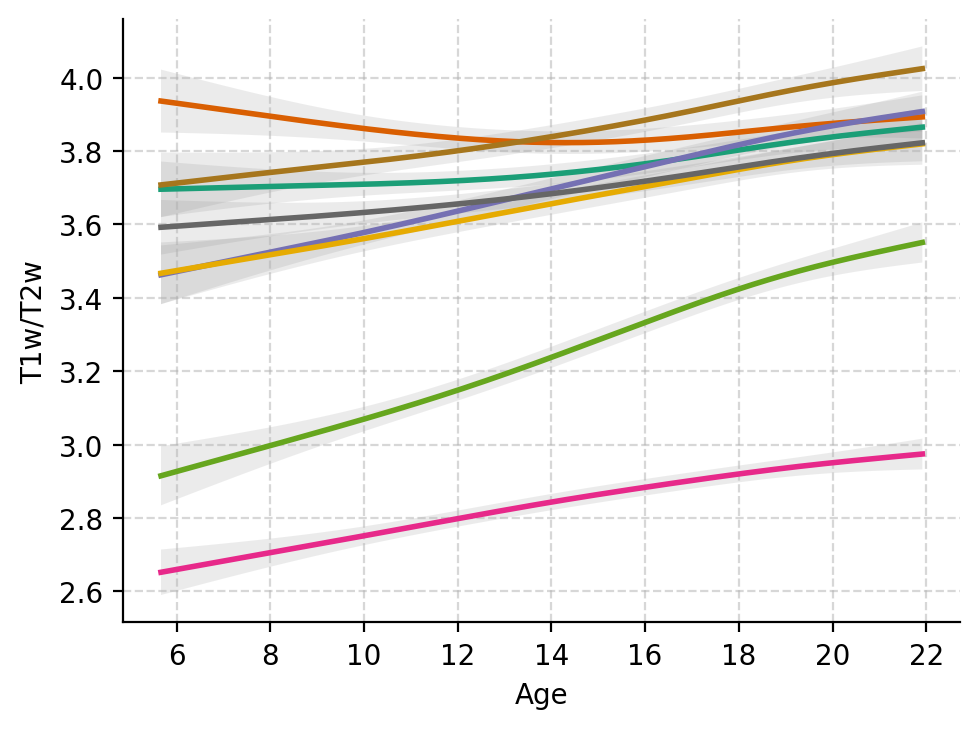

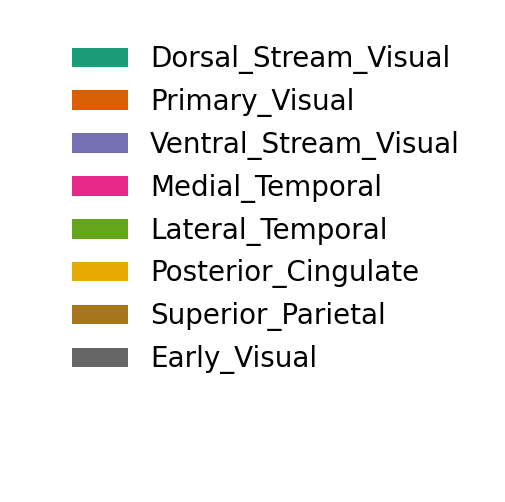

In [ ]:

tract_colors = dict(zip(cortices, plt.get_cmap('Dark2').colors))


fig, ax = plt.subplots(figsize=(5, 3.75))

for idx, cortex in enumerate(cortices):

    tracts = tract_info[tract_info.cortex == cortex]['label']

    data = pd.DataFrame()
    data['age'] = df['age']
    data['tract_myelin'] = df[tracts].mean(axis=1)
    data = data.dropna()

    x_grid, y_grid, ci = fit_gam(data['age'], data['tract_myelin'])

    ax.plot(
        x_grid, y_grid,
        lw=2,label=cortex, color=tract_colors[cortex]
    )
    ax.fill_between(
        x_grid, ci[:,0], ci[:,1],
        facecolor='tab:gray', alpha=0.15
    )


ax.set_xlabel('Age')
ax.set_ylabel('T1w/T2w')
ax.grid(linestyle='--', alpha=.5)
sns.despine()
plt.tight_layout()
plt.savefig(f'plots/tract_myelin_development.svg')


fig, ax = plt.subplots(figsize=(3,3))

for cortex in cortices:
    ax.bar(0,0, color=tract_colors[cortex], label=cortex)

ax.legend(frameon=False)
ax.axis('off')
plt.savefig(f'plots/tract_myelin_development_legend.svg')
plt.show()

In [25]:
for cortex in cortices:
    tracts = tract_info[tract_info.cortex == cortex]['label']
    print(f'{cortex}:')
    display(pg.linear_regression(X=df['age'], y=df[tracts].mean(axis=1), remove_na=True))


Dorsal_Stream_Visual:


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,3.58168,0.037192,96.302616,0.000000e+00,0.04479,0.043008,3.508620,3.654740
1,age,0.01224,0.002442,5.013279,7.283182e-07,0.04479,0.043008,0.007444,0.017037


Primary_Visual:


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,3.847749,0.042513,90.508423,0.000000,0.00003,-0.001857,3.764235,3.931263
1,age,0.000351,0.002799,0.125414,0.900243,0.00003,-0.001857,-0.005148,0.005850


Ventral_Stream_Visual:


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,3.295090,0.039286,83.874944,9.607616e-311,0.186776,0.185262,3.217918,3.372263
1,age,0.028616,0.002577,11.105623,6.152503e-26,0.186776,0.185262,0.023555,0.033678


Medial_Temporal:


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,2.557537,0.030398,84.134668,2.053322e-311,0.155938,0.154366,2.497823,2.617251
1,age,0.019859,0.001994,9.960382,1.470705e-21,0.155938,0.154366,0.015942,0.023776


Lateral_Temporal:


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,2.654343,0.039685,66.884618,1.037216e-261,0.326747,0.325486,2.576384,2.732302
1,age,0.041934,0.002605,16.098577,7.994175e-48,0.326747,0.325486,0.036817,0.047051


Posterior_Cingulate:


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,3.338598,0.041242,80.951275,4.483101e-303,0.114533,0.112884,3.257583,3.419614
1,age,0.022545,0.002705,8.334246,6.562151e-16,0.114533,0.112884,0.017231,0.027858


Superior_Parietal:


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,3.555731,0.043658,81.444415,3.226361e-295,0.094621,0.092853,3.46996,3.641503
1,age,0.021041,0.002876,7.314991,9.998465e-13,0.094621,0.092853,0.01539,0.026693


Early_Visual:


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,3.474502,0.036500,95.191280,0.000000e+00,0.073205,0.07148,3.402802,3.546203
1,age,0.015592,0.002394,6.512791,1.697765e-10,0.073205,0.07148,0.010889,0.020295
